In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xgboost import XGBClassifier
import os
from src.logger import LoggerService

In [3]:
def enriquecer_datos(df, logger: LoggerService):
    """
    Enriquece los datos con variables adicionales y transformaciones.
    
    Args:
        df (pd.DataFrame): DataFrame con los datos históricos
        
    Returns:
        pd.DataFrame: DataFrame enriquecido con nuevas características
    """
    logger.info("Iniciando proceso de enriquecimiento de datos")
    
    try:
        # Convertir fecha a datetime si no lo es (solo fecha, no hora)
        logger.info("Convirtiendo columna date a datetime")
        df['date'] =  pd.to_datetime(df['date'])
        
        # Variables temporales
        logger.info("Generando variables temporales")
        df['day_of_week'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['quarter'] = df['date'].dt.quarter
        
        # Retornos
        logger.info("Calculando retornos")
        df['returns'] = df['close'].pct_change()
        df['returns_prev_day'] = df['returns'].shift(1)
        
        # Volatilidad móvil (20 días)
        logger.info("Calculando volatilidad móvil de 20 días")
        df['volatility_20d'] = df['returns'].rolling(window=20).std()
        
        # Medias móviles
        logger.info("Calculando medias móviles")
        df['sma_20'] = df['close'].rolling(window=20).mean()
        df['sma_50'] = df['close'].rolling(window=50).mean()
        
        # RSI (Relative Strength Index)
        logger.info("Calculando RSI")
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # Variable objetivo
        logger.info("Generando variable objetivo")
        df['target'] = (df['close'] > df['close'].shift(1)).astype(int)
        
        # Eliminar filas con NaN
        logger.info("Eliminando filas con valores NaN")
        df_original_len = len(df)
        df = df.dropna()
        df_final_len = len(df)
        logger.info(f"Filas eliminadas: {df_original_len - df_final_len}")
        
        logger.info("Proceso de enriquecimiento completado exitosamente")
        return df
        
    except Exception as e:
        logger.error(f"Error en el proceso de enriquecimiento: {str(e)}")
        raise

def obtener_features(logger: LoggerService):
    """
    Retorna la lista de features utilizadas para el modelo.
    
    Returns:
        list: Lista de nombres de features
    """
    logger.info("Obteniendo lista de features para el modelo")
    features = [
        'returns_prev_day',
        'volatility_20d',
        'sma_20',
        'sma_50',
        'rsi',
        'day_of_week',
        'month',
        'quarter'
    ]
    logger.info(f"Features seleccionadas: {', '.join(features)}")
    return features

In [4]:
def realizar_eda(df, logger: LoggerService, save_path='src/static/eda/'):
    """
    Realiza análisis exploratorio de datos y guarda visualizaciones
    """
    logger.info("Iniciando análisis exploratorio de datos (EDA)")
    
    try:
        # Crear directorio si no existe
        logger.info(f"Creando directorio para visualizaciones: {save_path}")
        os.makedirs(save_path, exist_ok=True)
        
        # Distribución de la variable objetivo
        logger.info("Generando gráfico de distribución de la variable objetivo")
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='target')
        plt.title('Distribución de Movimientos de Precio')
        plt.savefig(f'{save_path}distribucion_target.png')
        plt.close()
        
        # Correlación entre variables
        logger.info("Generando matriz de correlación")
        plt.figure(figsize=(12, 8))
        correlation_matrix = df.select_dtypes(include=[np.number]).corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Matriz de Correlación')
        plt.tight_layout()
        plt.savefig(f'{save_path}correlacion.png')
        plt.close()
        
        # Series temporales
        logger.info("Generando gráfico de serie temporal")
        plt.figure(figsize=(15, 6))
        plt.plot(df['date'], df['close'])
        plt.title('Evolución del Precio de Cierre')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'{save_path}serie_temporal.png')
        plt.close()
        
        # Guardar estadísticas descriptivas
        logger.info("Guardando estadísticas descriptivas")
        stats = df.describe()
        stats.to_csv(f'{save_path}estadisticas_descriptivas.csv')
        
        logger.info("EDA completado exitosamente")
        
    except Exception as e:
        logger.error(f"Error durante el EDA: {str(e)}")
        raise

In [5]:
logger = LoggerService()

Ruta de logs configurada: src/logs
Directorio de logs creado/verificado en: src/logs
Archivo de log configurado: src/logs/log_2025-05-24.txt
Logger configurado exitosamente


In [6]:
"""
Entrena el modelo y lo guarda como model.pkl
"""
logger.info("Iniciando proceso de entrenamiento del modelo")

# Cargar datos
logger.info("Cargando datos históricos")
df = pd.read_csv('src/static/data/historical.csv')

In [7]:
# Enriquecer datos
logger.info("Enriqueciendo datos")
df = enriquecer_datos(df, logger)

In [8]:
df['date'] = pd.to_datetime(df['date']).dt.date
df_sorted = df.sort_values('date').reset_index(drop=True)

In [9]:
# Realizar EDA
logger.info("Realizando análisis exploratorio")
realizar_eda(df, logger)

In [10]:
# Preparar features
logger.info("Preparando features para el modelo")
features = obtener_features(logger)
X = df[features]
y = df['target']

In [11]:
split_idx = int(len(df_sorted) * 0.8)
train_data = df_sorted.iloc[:split_idx]
test_data = df_sorted.iloc[split_idx:]

X_train = train_data[features]
y_train = train_data['target']
X_test = test_data[features]
y_test = test_data['target']

In [12]:
print(f"Datos de entrenamiento: {len(X_train)} muestras")
print(f"Datos de prueba: {len(X_test)} muestras")
print(f"Fecha límite entrenamiento: {train_data['date'].max()}")
print(f"Fecha inicio prueba: {test_data['date'].min()}\n")


Datos de entrenamiento: 240 muestras
Datos de prueba: 61 muestras
Fecha límite entrenamiento: 2025-02-26
Fecha inicio prueba: 2025-02-27



In [13]:
# 1. ANÁLISIS DE LA DISTRIBUCIÓN DE CLASES
print("1. Análisis de distribución de clases:")
print(f"Train - Distribución: {y_train.value_counts().to_dict()}")
print(f"Test - Distribución: {y_test.value_counts().to_dict()}")
print(f"Train - Proporción clase 1: {y_train.mean():.3f}")
print(f"Test - Proporción clase 1: {y_test.mean():.3f}\n")

1. Análisis de distribución de clases:
Train - Distribución: {1: 123, 0: 117}
Test - Distribución: {1: 32, 0: 29}
Train - Proporción clase 1: 0.512
Test - Proporción clase 1: 0.525



In [14]:
# 2. ANÁLISIS DE CORRELACIONES ENTRE FEATURES
print("2. Análisis de correlaciones:")
correlation_matrix = X_train.corr()
print("Correlaciones altas (>0.7) entre features:")
high_corr = np.where(np.abs(correlation_matrix) > 0.7)
for i, j in zip(high_corr[0], high_corr[1]):
    if i < j:  # Evitar duplicados
        print(f"{correlation_matrix.index[i]} vs {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i,j]:.3f}")


2. Análisis de correlaciones:
Correlaciones altas (>0.7) entre features:
sma_20 vs sma_50: 0.970
month vs quarter: 0.971


In [15]:
correlation_matrix

,returns_prev_day,volatility_20d,sma_20,sma_50,rsi,day_of_week,month,quarter
returns_prev_day,1.000000,-0.035972,-0.056961,-0.047021,0.218311,0.060449,0.031839,0.022469
volatility_20d,-0.035972,1.000000,0.398538,0.422473,-0.213044,-0.015990,-0.204105,-0.207758
sma_20,-0.056961,0.398538,1.000000,0.969849,-0.166281,0.004067,0.154776,0.189923
sma_50,-0.047021,0.422473,0.969849,1.000000,-0.188310,0.005657,0.188800,0.210641
rsi,0.218311,-0.213044,-0.166281,-0.188310,1.000000,0.024414,0.036124,0.017636
day_of_week,0.060449,-0.015990,0.004067,0.005657,0.024414,1.000000,-0.027084,-0.029321
month,0.031839,-0.204105,0.154776,0.188800,0.036124,-0.027084,1.000000,0.971211
quarter,0.022469,-0.207758,0.189923,0.210641,0.017636,-0.029321,0.971211,1.000000


In [16]:
# 3. FEATURE ENGINEERING MEJORADA
print("\n3. Creando features adicionales...")

def create_enhanced_features(df):
    """Crear features adicionales más predictivas"""
    df_enhanced = df.copy()
    
    # Features de momentum
    df_enhanced['sma_ratio'] = (df['close'] - df['sma_20']) / df['sma_20']
    df_enhanced['sma_cross'] = np.where(df['sma_20'] > df['sma_50'], 1, 0)
    
    # Features de volatilidad
    df_enhanced['volatility_ratio'] = df['volatility_20d'] / df['volatility_20d'].rolling(60).mean()
    
    # Features de volumen (si disponible)
    if 'volume' in df.columns:
        df_enhanced['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    
    # Features de RSI
    df_enhanced['rsi_oversold'] = np.where(df['rsi'] < 30, 1, 0)
    df_enhanced['rsi_overbought'] = np.where(df['rsi'] > 70, 1, 0)
    
    # Features de returns múltiples
    df_enhanced['returns_2d'] = df['close'].pct_change(2)
    df_enhanced['returns_5d'] = df['close'].pct_change(5)
    
    return df_enhanced


3. Creando features adicionales...


In [17]:
# Aplicar feature engineering
df_enhanced = create_enhanced_features(df_sorted)

# Nuevas features
enhanced_features = [
    'returns_prev_day',
    'volatility_20d',
    'sma_20',
    'sma_50',
    'rsi',
    'day_of_week',
    'month',
    'quarter',
    'sma_ratio',
    'sma_cross',
    'volatility_ratio',
    'rsi_oversold',
    'rsi_overbought',
    'returns_2d',
    'returns_5d'
]

# Remover NaN
df_clean = df_enhanced.dropna()

# Nueva división temporal
split_idx = int(len(df_clean) * 0.8)
train_enhanced = df_clean.iloc[:split_idx]
test_enhanced = df_clean.iloc[split_idx:]

X_train_enh = train_enhanced[enhanced_features]
y_train_enh = train_enhanced['target']
X_test_enh = test_enhanced[enhanced_features]
y_test_enh = test_enhanced['target']

print(f"Datos después de feature engineering: {len(df_clean)} muestras")
print(f"Features adicionales creadas: {len(enhanced_features) - len(features)}\n")


Datos después de feature engineering: 242 muestras
Features adicionales creadas: 7



In [18]:
# 4. COMPARACIÓN DE MÚLTIPLES ALGORITMOS
print("4. Comparando múltiples algoritmos:")

models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Entrenar modelo
    model.fit(X_train_enh, y_train_enh)
    
    # Predicciones
    y_pred = model.predict(X_test_enh)
    y_pred_proba = model.predict_proba(X_test_enh)[:, 1]
    
    # Métricas
    accuracy = accuracy_score(y_test_enh, y_pred)
    auc = roc_auc_score(y_test_enh, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'model': model
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")

4. Comparando múltiples algoritmos:

--- RandomForest ---
Accuracy: 0.7959
AUC: 0.8545

--- XGBoost ---
Accuracy: 0.8980
AUC: 0.9632

--- LogisticRegression ---
Accuracy: 0.6122
AUC: 0.7642


In [19]:
# 5. MEJOR MODELO
print("\n5. Resumen de resultados:")
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']

print(f"Mejor modelo: {best_model_name}")
print(f"Mejor AUC: {results[best_model_name]['auc']:.4f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")


5. Resumen de resultados:
Mejor modelo: XGBoost
Mejor AUC: 0.9632
Accuracy: 0.8980


In [20]:
# 6. ANÁLISIS DE THRESHOLD ÓPTIMO
print(f"\n6. Optimización de threshold para {best_model_name}:")

y_pred_proba_best = best_model.predict_proba(X_test_enh)[:, 1]

# Probar diferentes thresholds
thresholds = np.arange(0.3, 0.8, 0.05)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_best >= threshold).astype(int)
    
    # Calcular F1-score
    f1 = f1_score(y_test_enh, y_pred_thresh)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
    
    print(f"Threshold {threshold:.2f}: F1={f1:.3f}, Accuracy={accuracy_score(y_test_enh, y_pred_thresh):.3f}")

print(f"\nMejor threshold: {best_threshold:.2f} (F1={best_f1:.3f})")


6. Optimización de threshold para XGBoost:
Threshold 0.30: F1=0.842, Accuracy=0.816
Threshold 0.35: F1=0.842, Accuracy=0.816
Threshold 0.40: F1=0.842, Accuracy=0.816
Threshold 0.45: F1=0.873, Accuracy=0.857
Threshold 0.50: F1=0.906, Accuracy=0.898
Threshold 0.55: F1=0.906, Accuracy=0.898
Threshold 0.60: F1=0.902, Accuracy=0.898
Threshold 0.65: F1=0.902, Accuracy=0.898
Threshold 0.70: F1=0.902, Accuracy=0.898
Threshold 0.75: F1=0.902, Accuracy=0.898

Mejor threshold: 0.50 (F1=0.906)



7. Feature Importance - XGBoost:
             feature  importance
13        returns_2d    0.298045
0   returns_prev_day    0.285958
14        returns_5d    0.116695
2             sma_20    0.057028
5        day_of_week    0.055062
4                rsi    0.045150
1     volatility_20d    0.033294
6              month    0.033087
3             sma_50    0.029308
10  volatility_ratio    0.025330


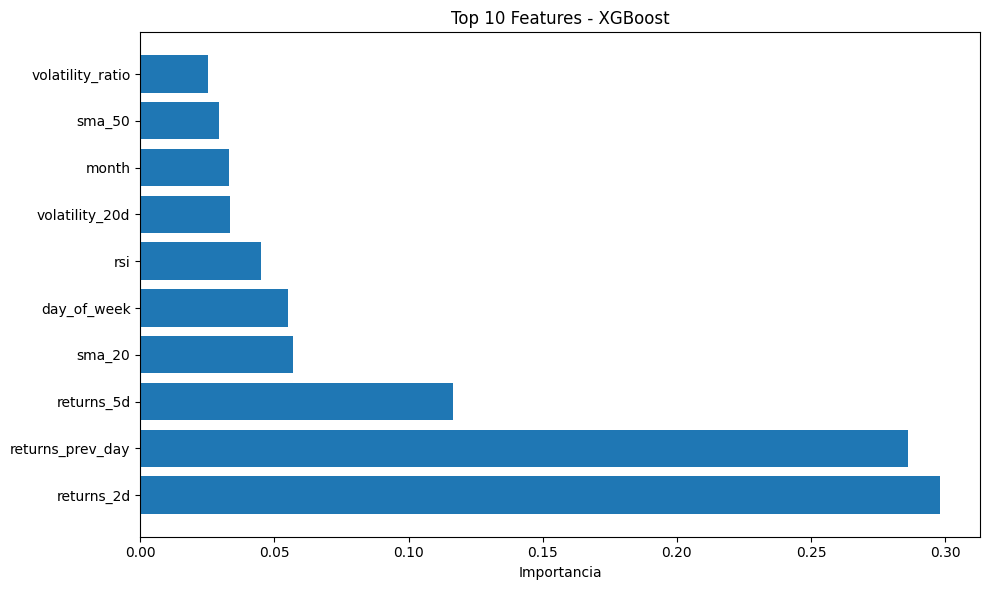

In [21]:
# 7. FEATURE IMPORTANCE DEL MEJOR MODELO
print(f"\n7. Feature Importance - {best_model_name}:")
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': enhanced_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(importance_df.head(10))
    
    # Gráfico de importancia
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
    plt.title(f'Top 10 Features - {best_model_name}')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()